In [45]:
# import the required Libraries
import pandas as pd
import geopandas as gpd
from shapely import wkt
import folium
from folium.plugins import HeatMap

## Load the data

In [46]:
# Load the data
file_path = 'Data\\2021_Federal_Census__Visible_Minorities_20231228.csv'
data = pd.read_csv(file_path)

## Distribution of Different Minorities

In [47]:
# Filtering data where gender is 'Total' and recalculating the total count for each minority group across the entire dataset
total_minority_distribution = data[data['Gender'] == 'Total'].groupby('Characteristic')['Value'].sum().sort_values(ascending=False)

total_minority_distribution

Characteristic
Not a visible minority               570180.0
Total visible minority population    426150.0
South Asian                          114915.0
Black                                 75400.0
Filipino                              70465.0
Chinese                               59720.0
Arab                                  30145.0
Latin American                        19290.0
Southeast Asian                       18850.0
Multiple visible minorities           13850.0
Korean                                 7510.0
West Asian                             6865.0
Visible minority, n.i.e.               3690.0
Japanese                               1680.0
Name: Value, dtype: float64

The data reveals a diverse population with a visible minority count of 426,150 against 570,180 not identified as such. South Asian, Black, and Filipino groups dominate, indicating significant cultural diversity.

## Distribution of Different Minorities by Gender

In [48]:
# Calculating the total count for each minority group by gender
gender_distribution = data.groupby(['Characteristic', 'Gender'])['Value'].sum().unstack()

# Sorting by the total count for better visibility
gender_distribution = gender_distribution.sort_values(by='Men+', ascending=False)

gender_distribution

Gender,Men+,Total,Women+
Characteristic,,,
Not a visible minority,285870.0,570180.0,284425.0
Total visible minority population,210145.0,426150.0,216030.0
South Asian,58555.0,114915.0,56370.0
Black,37890.0,75400.0,37485.0
Filipino,32395.0,70465.0,38045.0
Chinese,28885.0,59720.0,30750.0
Arab,15745.0,30145.0,14305.0
Latin American,9340.0,19290.0,9830.0
Southeast Asian,8735.0,18850.0,9930.0


For most minority groups, the distribution between Men+ and Women+ is relatively balanced.
Notably, the Filipino group has a higher count for Women+ compared to Men+.

## The Simpson's Diversity Index for Visible Minority
https://medium.com/@waldoch/measuring-neighborhood-diversity-with-python-f32574f79ff0

In [51]:
def simpsons_diversity_index(counts):
    n = sum(counts)
    return 1 - sum((n_i * (n_i - 1) / (n * (n - 1))) for n_i in counts if n > 1)

# Filtering data for 'Total' gender and excluding the total counts and not a visible minority counts to focus on diversity within minorities
total_diversity_data = data[(data['Gender'] == 'Total') & ~data['Characteristic'].isin(['Total visible minority population', 'Not a visible minority'])]

# Grouping the data by neighborhood and Neighbourhood Number
grouped_data = total_diversity_data.groupby(['Neighbourhood', 'Neighbourhood Number'])

# Calculating the diversity index for each neighborhood 
total_neighborhood_diversity = grouped_data.apply(
    lambda x: simpsons_diversity_index(x['Value'].tolist())
).reset_index(name='Diversity Index')  # 'Diversity Index' is the new column for the calculated index

# Sorting the values by the diversity index
total_neighborhood_diversity = total_neighborhood_diversity.sort_values(by='Diversity Index', ascending=False)

# Displaying the top 10 diverse neighborhoods
total_neighborhood_diversity.head(10)

,Neighbourhood,Neighbourhood Number,Diversity Index
218,Riverview Area,4463,1.000000
105,Goodridge Corners,3490,1.000000
82,Edmonton South West,8888,1.000000
31,Bonnie Doon,6040,0.886106
125,Holyrood,6310,0.874815
191,Ottewell,6550,0.873885
198,Parkview,3330,0.868509
129,Idylwylde,6320,0.867309
169,Mayliewan,2511,0.865730
143,King Edward Park,6360,0.864429


The neighborhoods of Riverview Area, Goodridge Corners, and Edmonton South West maintain the highest diversity index, suggesting a very diverse population in terms of visible minorities.

## Map the The Simpson's Diversity Index for Visible Minority

In [50]:
# Read the CSV file with multipolygon data
location_data = pd.read_csv('Data\\2021_Federal_Census__Neighbourhoods_as_of_Official_Census_Day_20231228.csv')
# Convert the multi-polygon data column from WKT to actual geometry objects
location_data['the_geom'] = location_data['the_geom'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(location_data, geometry='the_geom')

## Combine The Data

In [40]:
# Ensure the IDs are of the same type (int)
total_neighborhood_diversity['Neighbourhood Number'] = total_neighborhood_diversity['Neighbourhood Number'].astype(int)
location_data['neighbourh'] = location_data['neighbourh'].astype(int)

# Merge the DataFrames on the neighborhood IDs
combined_gdf = location_data.merge(total_neighborhood_diversity, left_on='neighbourh', right_on='Neighbourhood Number')

## Create And Display The Map

In [44]:
# Create the map
m = folium.Map(location=[combined_gdf.the_geom.iloc[0].centroid.y, combined_gdf.the_geom.iloc[0].centroid.x], zoom_start=12)

#Create the heatmap layer using The Simpson's Diversity Index
# Generate heat data considering 'diversity_index' is a column in the combined_gdf
heat_data = [[geom.centroid.y, geom.centroid.x, index] for geom, index in zip(combined_gdf.the_geom, combined_gdf['Diversity Index'])]

# Add the HeatMap layer to the map
folium.plugins.HeatMap(heat_data).add_to(m)

# Show the map
m

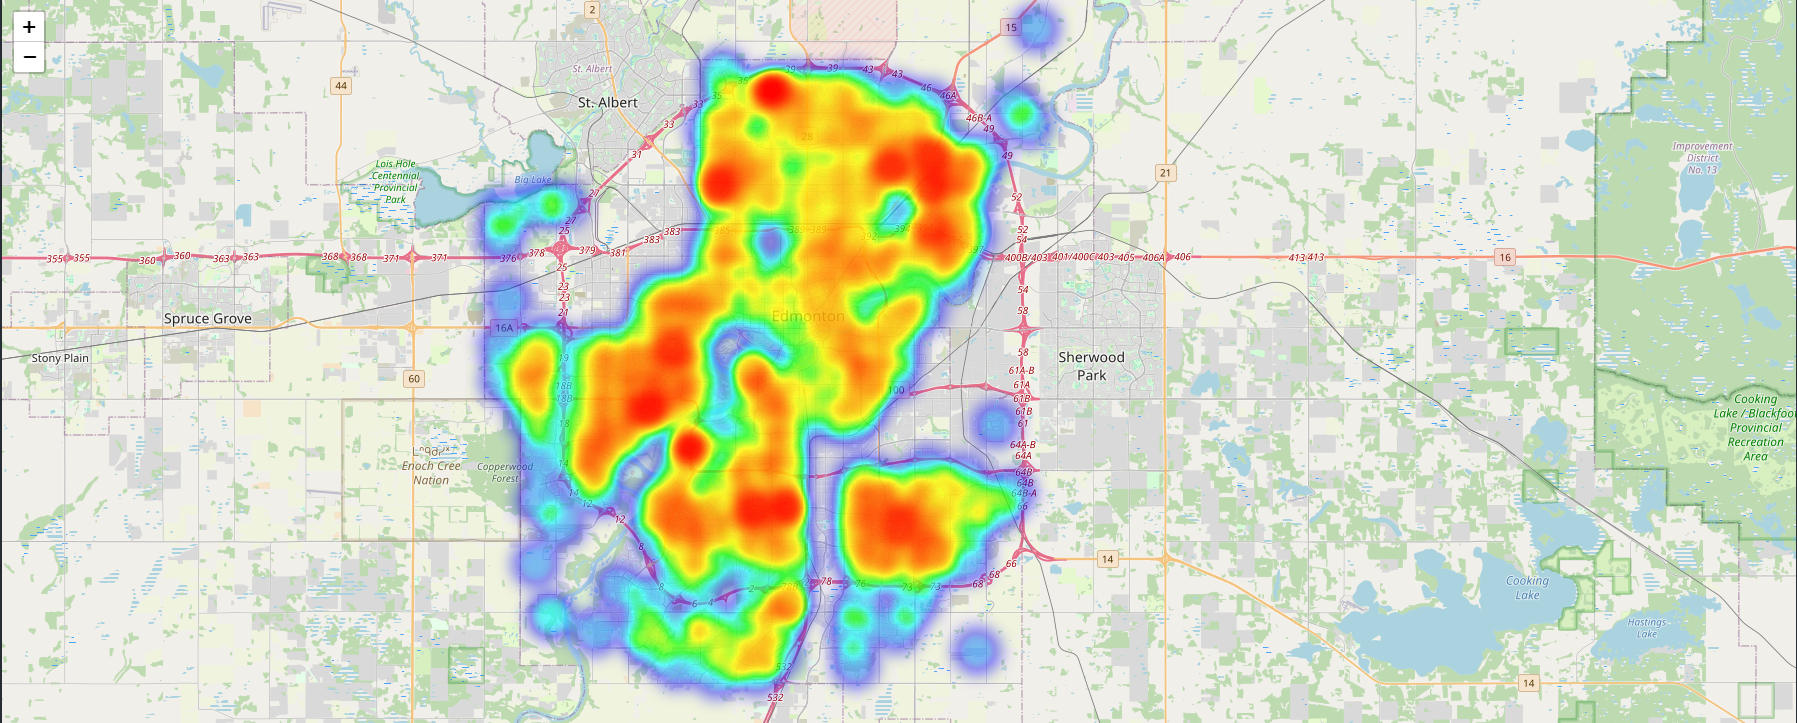